## EECS 491 Assignment 3

Due Mon Mar 29 before midnight. 95 points total.

### Submitting assignments to Canvas

- For jupyter notebooks, submit the .ipynb file and a pdf or html export of the notebook.  Make sure the output represents the latest state of your notebook.  If you use interactive plots, make sure the output for the static file is representative of the points you wish to make.  If your are not using notebooks, writeup your assignment using latex and submit a pdf with your code.  The writeup should include relevant code with description if it can fit on a page.  Do not include binaries or large data files.

- Use the following format for filenames:
  - `EECS491-A3-yourcaseid.ipynb`
  - `EECS491-A3-yourcaseid.pdf`

- If you have more than these two files, put all your files in a directory named `EECS491-A3-yourcaseid`. Then zip the directory and submit it with the name `EECS491-A3-yourcaseid.zip`.  Do not use other compression formats.

In [1]:
import numpy as np
from random import shuffle

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image as cv
matplotlib.rc('image', cmap='gray')

### Exercise 1. MRFs and Images Denoising (40 points)

In this problem, you will implement the image de-noising example using a Markov Random Field (MRF).  This material on MRFs is covered in the textbook (Barber) in chapter 4.2.5. The lecture and this problem is based on the presentation in Bishop in chapter 8.3, which is available online.

As discussed in class, energy function for this MRF is

$$ E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_i\sum_{j\in \textrm{ne}(i)} x_i x_j - \eta \sum_i x_i y_i $$

where the binary variables $x_i$ represent the unknown, noise-free image pixels, which are binary, i.e. black or white, and $\textrm{ne}(i)$ indicates the neighbords of node $i$.  The variables $y_i$ represent the observed noisy pixels, i.e. the pixel could randomly change from black ($=-1$) to white ($=+1$) or vice-versa.  

The corresponding joint probability distribution over the variables is

$$ p(\mathbf{x},\mathbf{y}) = \frac{1}{Z} \exp \left[ -E(\mathbf{x},\mathbf{y}) \right] $$

#### 1.1 (5 pts) Derive the equation that specifies the change in the energy equation when one variable changes state.

The total energy is given above as:
$$ E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_i\sum_{j\in \textrm{ne}(i)} x_i x_j - \eta \sum_i x_i y_i $$
We can then "let out" $x_k$ to produce the following:
$$ E(x, y) = (h \sum_{i / k} x_i - \beta \sum_{i / k} \sum_{j \in ne(x_i) / k} x_i x_j - \eta \sum_{i / k} x_i y_i) + h \cdot x_k - \beta \sum_{j \in ne(x_k) }x_k x_j - \beta \sum_{j \in ne(x_k) } x_j x_k- \eta x_k y_k \\
    = C + h \cdot x_k - \beta \sum_{j \in ne(x_k) }x_k x_j - \beta \sum_{j \in ne(x_k)}  x_j x_k- \eta x_k y_k $$
Next, we can assume that $x_k$ is $\overline{x}$, we can produce the following:
$$ E(\overline{x}, y) = (h \sum_{i / k} x_i - \beta \sum_{i / k} \sum_{j \in ne(x_i) / k} x_i x_j - \eta \sum_{i / k} x_i y_i) + h \cdot x_k - \beta \sum_{j \in ne(x_k) }x_k x_j - \beta \sum_{j \in ne(x_k) } x_j x_k- \eta x_k y_k \\
    = C + h \cdot (-x_k) - \beta \sum_{j \in ne(x_k)} (-x_k) x_j - \beta \sum_{j \in ne(x_k) }x_j (-x_k) - \eta (-x_k) y_k $$ 

Therefore, the change in energy can be defined as:
$$ \Delta E = E(\overline{x}, y) - E(x, y) \\
\Delta E = C - C -2 h \cdot x_k -4\beta \sum_{j \in ne(x_k)} (-x_k) x_j + 2 \eta x_k y_k \\
\Delta E = -2 h \cdot x_k + 4\beta \sum_{j \in ne(x_k)} x_k x_j + 2 \eta x_k y_k $$

#### 1.2 (10 pts) Write a program to iteratively (or in random order) update the state variables to minimize the energy (maximize the probability).  Explain the design of your code.  

In [2]:
def add_noise(img:np.array, prop_noise:float=0.05):
    # copy
    noised = np.copy(img)
    
    # iterate over pixels, flip the value if below the threshold
    for m in range(noised.shape[0]):
        for n in range(noised.shape[1]):
            if np.random.uniform(0, 1) < prop_noise:
                noised[m][n] = -noised[m][n]
            
    # return
    return noised

In [3]:
def neighbor_sum(x:np.array, i:int, j:int):
    # inner method to get the value of a specific pixel
    def get_pixel_value(x, i, j):
        try:
            return x[i][j]
        except IndexError:
            return 0
        
    # calculate sum of neighbors and return
    return x[i][j] * (get_pixel_value(x, i+1, j) + get_pixel_value(x, i-1, j) + get_pixel_value(x, i, j+1) + get_pixel_value(x, i, j-1))

In [4]:
def minimize_energy(img:np.array, h:float=5, beta:float=5, eta:float=5, plot:bool=False, cap:bool=False, n_function=neighbor_sum):
    # copy the img to make changes
    result = np.copy(img)
    E_tot = 0
    
    # if plot is True, calc and store starting energy
    if plot:
        cache = []
        E_tot = np.sum( np.array([(h*img[m][n]) + (-beta * neighbor_sum(img, m, n)) + (-eta * img[m][n]**2) for n in range(img.shape[1]) for m in range(img.shape[0])]) )
        cache.append( E_tot )
        
        # start a counter
        iter_count = [0]
        
    # iterate over values, calc energy, store if needed
    E = 0
    counter = 0
    randm = [i for i in range(img.shape[0])]; shuffle(randm) # to randomly denoise
    randn = [i for i in range(img.shape[1])]; shuffle(randn) # to randomly denoise
    for m in randm:
        for n in randn:
            
            # calc energy
            E = (-2*h*result[m][n]) + (4*beta*n_function(result, m, n) + (2*eta*result[m][n]*img[m][n]))
            
            # negate the value in the image if E tells us to
            if E < 0:
                result[m][n] = -result[m][n]
                E_tot += E
                
            # track the changes made
            if plot:
                iter_count.append( iter_count[-1]+1 )
                cache.append(E_tot)
                
            # exit if cap is reached (50% of pixels)
            if cap:
                if counter >= result.size/2:
                    break
            counter += 1
    
    # return the necessary info
    if plot:
        return result, iter_count, cache
    else:
        return result

The third cell for this problem contains the algorithm for my code. The first cell contains a method to add noise to images and the second cell contains a helper method which calculates the value(s) of surrounding pixels to help in probability calculations. Generally, the process that my algorithm goes to is as follows:
- Select a pixel to update
- Calculate the change in energy ($\Delta E$) based on the three input parameters ($h$, $\beta$, $\eta$) for the selected pixel
- If the $\Delta E$ is found to be negative, flip the pixel as a lower energy points to a greater probability
- Continue to the next pixel and repeat the process

#### 1.3 (5 pts) Show that your update algorithm minimizes the energy function $E(\mathbf{x}, \mathbf{y})$ and converges by plotting the energy vs the number of passes through the set of pixels.

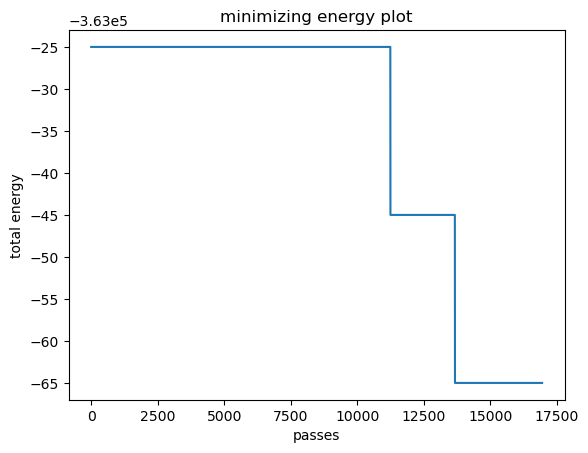

In [5]:
# read in the image
img = cv.imread("grizzly.png")
img[img < 0.5] = -1
img[img >= 0.5] = 1

# add noise to image
noisy = add_noise(img, prop_noise=0.05)

# denoise
result, P, C = minimize_energy(img, plot=True)

# plot the energy curve
plt.plot(P, C)
plt.xlabel("passes")
plt.ylabel("total energy")
plt.title("minimizing energy plot")
plt.show()

#### 1.4 (5 pts) Illustrate the model by showing the state of the denoised image at the points: at the start before updating, when it is about 50% converged in terms of energy minimization, and at the end when it converges.  Choose images that aren't too high resolution so that the individual pixels are visible as squaures.  You may also do a live plot in a notebook to show it updating continuously, but make sure you have the static plots too in case the dynamic plot has portability issues.

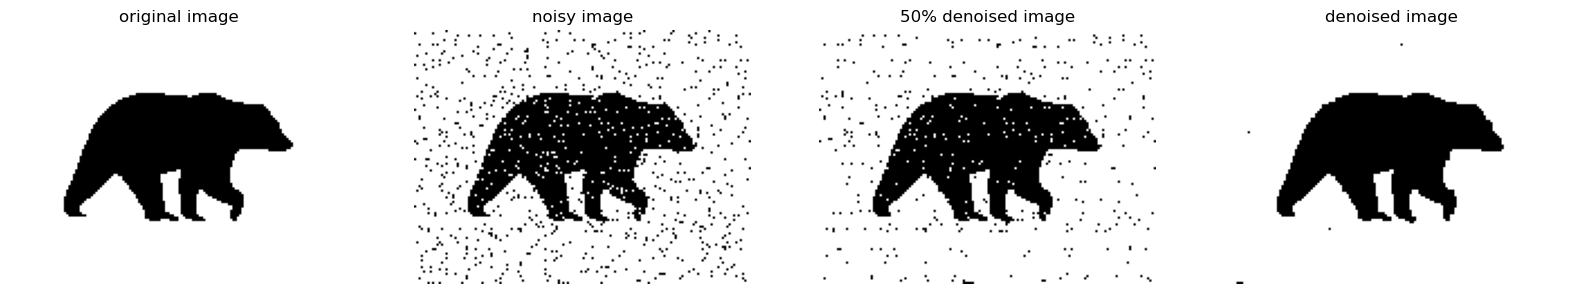

In [6]:
# read in the image
img = cv.imread("grizzly.png")
img[img < 0.5] = -1
img[img >= 0.5] = 1

# add noise to image
noisy = add_noise(img, prop_noise=0.05)

# denoise to 50%
res_50 = minimize_energy(noisy, cap=True)

# denoise tp 100%
result = minimize_energy(noisy)

# show the images
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(20, 60)
ax[0].imshow(img)
ax[0].set_title("original image")
ax[0].set_axis_off()
ax[1].imshow(noisy)
ax[1].set_title("noisy image")
ax[1].set_axis_off()
ax[2].imshow(res_50)
ax[2].set_title("50% denoised image")
ax[2].set_axis_off()
ax[3].imshow(result)
ax[3].set_title("denoised image")
ax[3].set_axis_off()
plt.show()

#### 1.5 (5 pts) Experiment with different settings of the energy equation parameters and explain your results in terms of their effect on the energy equation.

There are three parameters which are given to the model. These are $h$, $\beta$, and $\eta$ which each impact a different part of our model. Let's read in the example image and add some noise so it can be used in the trials below.

In [7]:
# read in the image
img = cv.imread("grizzly.png"); img[img < 0.5] = -1; img[img >= 0.5] = 1

# noise the image
noisy = add_noise(img)

First, let us consider $h$. $h$ serves bias for the model. When $h$ is positive, the model prefers black pixels, where the value of the pixel is 1, while when $h$ is negative, the model prefers white pixels, where the value of the pixel is -1. We can confirm this by running our denoising model with $h$=-10 and $h$=10. Then we can quantify the number of white and black pixels in each, where we can expect the model with $h$=-5 to have more white pixels and our model with $h$=5 to have more black pixels.

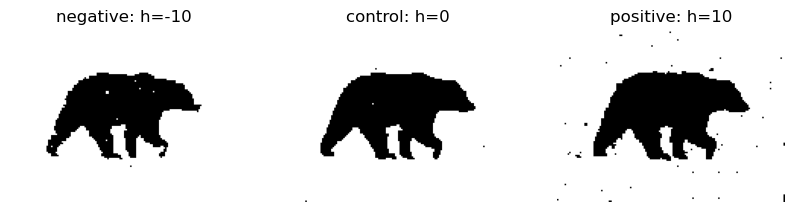

        pixel values
h=-10        10444.0
h=0           9954.0
h=10          9374.0


In [8]:
# denoise with varying h and default other params
h_neg = minimize_energy(noisy, h=-10); h_pos = minimize_energy(noisy, h=10); h_con = minimize_energy(noisy, h=0)

# plt the results
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(10, 30)
ax[0].imshow(h_neg); ax[0].set_title("negative: h=-10"); ax[0].set_axis_off()
ax[1].imshow(h_con); ax[1].set_title("control: h=0"); ax[1].set_axis_off()
ax[2].imshow(h_pos); ax[2].set_title("positive: h=10"); ax[2].set_axis_off()
plt.show()

# show the proportions
print(f"        pixel values")
print(f"h=-10        {np.sum(np.ravel(h_neg))}")
print(f"h=0           {np.sum(np.ravel(h_con))}")
print(f"h=10          {np.sum(np.ravel(h_pos))}")

As seen in the trial above, our model returned the expected result, where $h<0$ results in pixel values with more white pixels while $h>0$ returns pixel values with more black. This makes sense in terms of our equations as well because a negative $h$ results in a positive $h$ term, which is more likely to result in a white pixel. The opposite is true for $h>0$ which results in a negative $h$ term, which is more likely to result in a black pixel.

Next, we can consider the $\beta$ parameter. I believe $\beta$ serves as a 'clustering' parameter. Changing $\beta$ will change the amount of effect that neighboring pixels have on the pixel of interest. We can again test this by testing negative and positive values of $\beta$. I would expect that negative values of $\beta$ would result in flipping a pixel when its neighboring pixels are similar while a positive value of beta would result in flipping a pixel when its neighboring pixels are dissimilar.

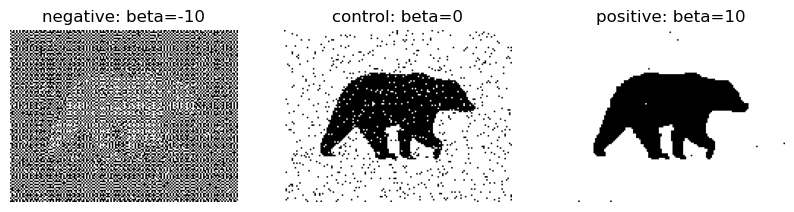

In [9]:
# denoise with varying B and default other params
B_neg = minimize_energy(noisy, beta=-10); B_pos = minimize_energy(noisy, beta=10); B_con = minimize_energy(noisy, beta=0)

# plt the results
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(10, 30)
ax[0].imshow(B_neg); ax[0].set_title("negative: beta=-10"); ax[0].set_axis_off()
ax[1].imshow(B_con); ax[1].set_title("control: beta=0"); ax[1].set_axis_off()
ax[2].imshow(B_pos); ax[2].set_title("positive: beta=10"); ax[2].set_axis_off()
plt.show()

As seen in the trial above, our hypothesis about $\beta$ can be confirmed because the image on the left, where $\beta$ is negative results in an image where the pixels are flipped when the neighboring pixels are similar resulting in an image which might be nice as a rug, but not in the case of denoising. However, the image with $\beta=10$ results in a fairly well denoised image where pixels are flipped when the neighboring pixels are dissimilar. Aside: $\beta=0$ results in an image in which almost no denoising is performed since our algorithm depends on the values of the pixel-of-interest's neighbors. Since we set $\beta$ to 0, this term is reduced to 0, making no impact on the flipping of the pixel.

Lastly, we can consider the term $\eta$. A large value of $\eta$ encourages the model to flip the pixel of interest. This is unlikely to be helpful unless we know that our image contains little noise or a lot of noise. Therefore, I believe the $\eta$ term represents the user's willingness to allow a pixel to be flipped. We can view this relationship below using negative and positive values for $\eta$.

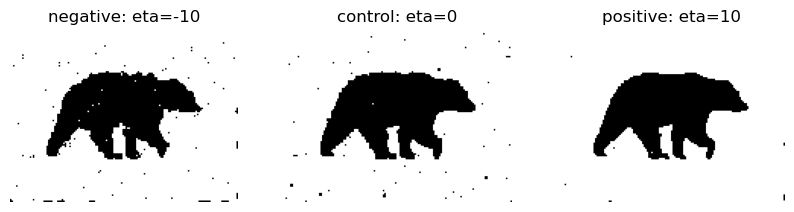

In [10]:
# denoise with varying eta and default other params
n_neg = minimize_energy(noisy, eta=-10); n_pos = minimize_energy(noisy, eta=10); n_con = minimize_energy(noisy, eta=0)

# plt the results
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(10, 30)
ax[0].imshow(n_neg); ax[0].set_title("negative: eta=-10"); ax[0].set_axis_off()
ax[1].imshow(n_con); ax[1].set_title("control: eta=0"); ax[1].set_axis_off()
ax[2].imshow(n_pos); ax[2].set_title("positive: eta=10"); ax[2].set_axis_off()
plt.show()

Above, we can see this relationship visualized where $\eta<0$ results in fewer flipped pixels while $\eta>0$ results in more flipped pixels.

#### 1.6 (10 pts)  Generalize the energy equation so that the model better captures different structure.  Explain your rationale behind this new model (i.e. terms in the equation). Illustrate it with denoising examples (other types of images) with are not well-handled by the previous model.

One generalization that can be made is with regards to the surrounding pixels. Currently, my model takes into account the pixels directly above, below, to the right, and to the left of the pixel of interest. However, with this method, we lose the data of the pixels in the corners (upper right, upper left, bottom right, and bottom left). Adding this data to the model would likely give higher precision and better accuracy. Accomplishing this is fairly easy as I can utilize the method I created earlier (neighbor_sum) but taking into account these additional neighbors. This new method is shown below.

In [11]:
def neighbors(x:np.array, i:int, j:int):
    # inner method to get the value of a specific pixel
    def get_pixel_value(x, i, j):
        try:
            return x[i][j]
        except IndexError:
            return 0
        
    # calculate sum of neighbors and return
    return x[i][j] * (get_pixel_value(x, i+1, j) + get_pixel_value(x, i-1, j) + get_pixel_value(x, i, j+1) + get_pixel_value(x, i, j-1) 
                      + get_pixel_value(x, i+1, j+1) + get_pixel_value(x, i-1, j-1) + get_pixel_value(x, i-1, j+1) + get_pixel_value(x, i+1, j-1))

Looking back at the algorithm I developed above (minimize_energy), I have added a parameter called 'n_function' which takes the function that the user would prefer to use (neighbor_sum or neighbors) to help calculate the $\beta$ term.

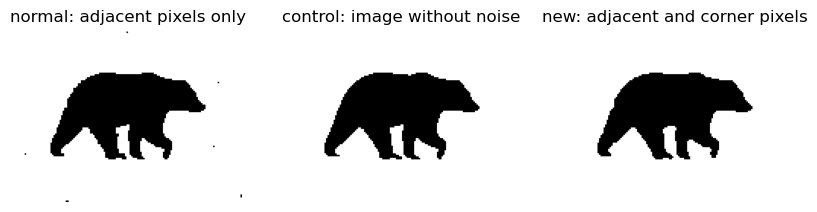

In [12]:
# denoise with varying neighbor_sum functions and default other params
n_sum = minimize_energy(noisy, n_function=neighbor_sum); n_ = minimize_energy(noisy, n_function=neighbors);

# plt the results
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(10, 30)
ax[0].imshow(n_sum); ax[0].set_title("normal: adjacent pixels only"); ax[0].set_axis_off()
ax[1].imshow(img); ax[1].set_title("control: image without noise"); ax[1].set_axis_off()
ax[2].imshow(n_); ax[2].set_title("new: adjacent and corner pixels"); ax[2].set_axis_off()
plt.show()

As can be seen above, this small generalization helped our model generously filter out additional noise such as that noise above the bear's head, at the edge of the image and in the bear's body. This is important especially at the edges of the image because the pixels of interest do not have additional pixels to reference to the right, left, above or below when they are against the edge. Adding pixels from the corners of the images help to generalize the model in these situations where these additional pixels are not there. <br><br>
Additionally, below I show that with increasing noise, the original model struggles while the improved model performs better.

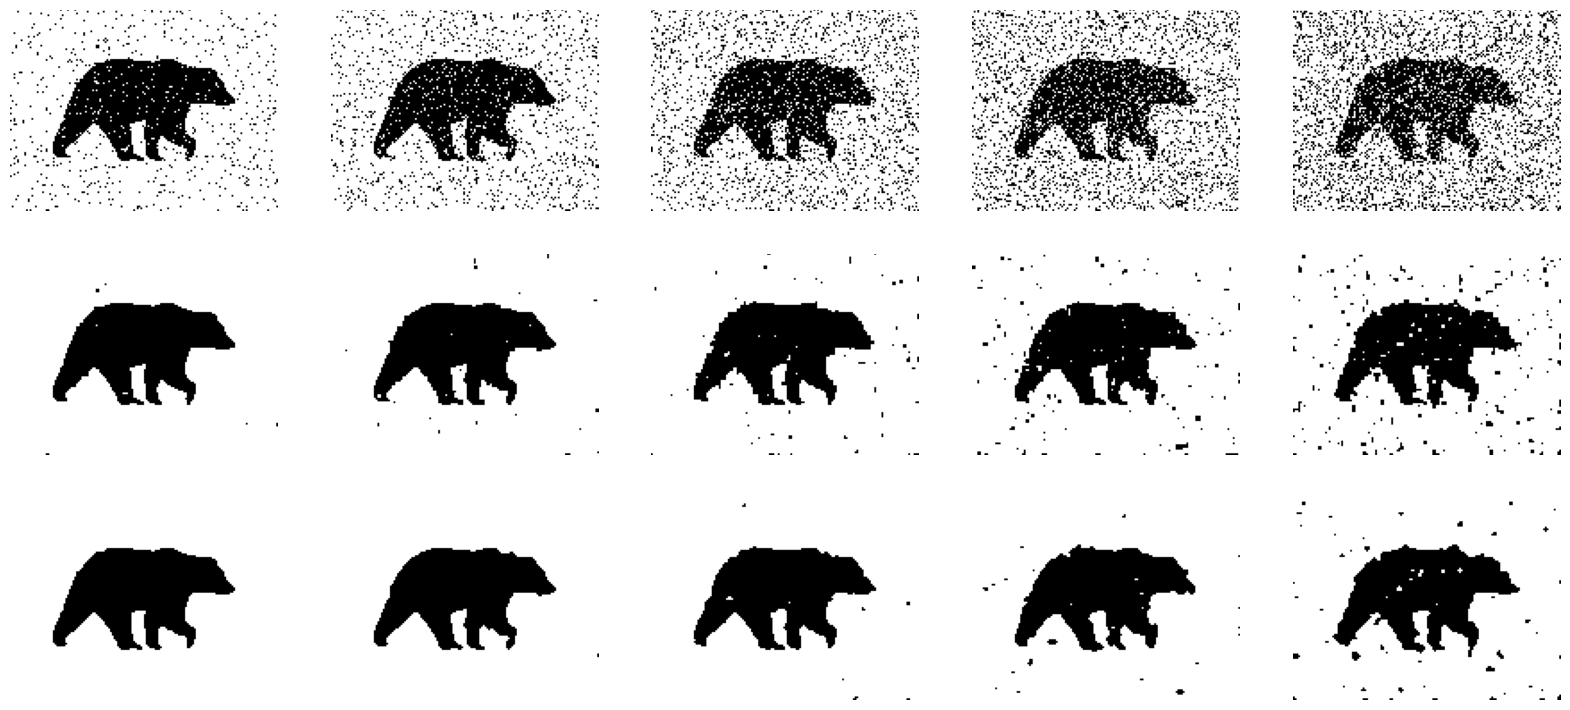

In [13]:
# generate set of image with differing levels of noise
noisy_imgs = [add_noise(img, prop) for prop in [0.04, 0.08, 0.12, 0.16, 0.2]]

# loop over the noisy images with different n_function
norm_denoised = [minimize_energy(ni, n_function=neighbor_sum) for ni in noisy_imgs]
new_denoised = [minimize_energy(ni, n_function=neighbors) for ni in noisy_imgs]
denoised = [noisy_imgs, norm_denoised, new_denoised]

# plot
fig, ax = plt.subplots(3, 5, sharex=True, sharey=True)
fig.set_size_inches(20, 9)
for i in range(len(denoised)):
    for j in range(len(norm_denoised)):
        ax[i][j].imshow(denoised[i][j])
        ax[i][j].set_axis_off()
plt.show()

Above, the first row shows the noisy images with noise proportions of <0.04, 0.08, 0.12, 0.16, 0.2>. The second row shows these noisy images denoised using the original denoising method. The third row shows these noisy images denoised using my new method. You can see how the new denoising method performs much better, especially as the proportion of noise increases. While neither method performs very well with high levels of noise, the original method struggles to create a fixed form while, with the new method, one can still make out the shape of the bear in the image.

### Exercise 2. Graphical Representation (15 points)

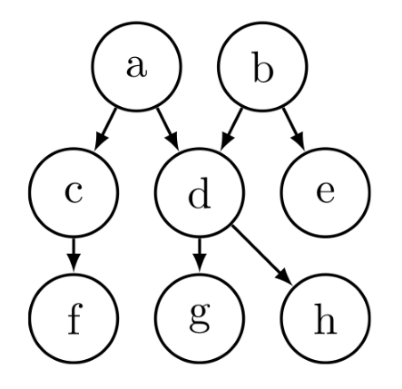

In [14]:
img = cv.imread("20problem.png")
plt.imshow(img)
plt.axis("off")
plt.show()

#### 2.1 (5 pts) For the Bayesian network show above, draw the corresponding Markov Random Field (MRF), and write out the joint probability using potential functions.  You do not need to specify the functions themselves, only which arguments they take.  What are the potential functions in terms of the Bayes net?

The markov random field can be defined by the parents, children, and parents-of-children of the node of interest. Defining the network as a Bayes Net, we get the probability function:
$$ p(a,b,c,d,e,f,g)=p(h|d)p(g|d)p(f|c)p(c|a)p(d|a,b)p(e|b)p(a)p(b) $$
We can define the Markov Random Field by connecting the parents and defining potential functions which connect cliques in the graph:
$$ p(a,b,c,d,e,f,g)=\psi(a,c)\psi(c,f)\psi(a,b,d)\psi(d,g)\psi(d,h)\psi(b,e) $$

#### 2.2 (5 pts) Now specify the Bayes net as a factor graph.  Again write the expression for the joint probability, but using factor functions.

A factor graph represents the Bayes Net where each node, rather than being directly connected to its child/parent node, is instead connected to a function which computes the parent/child probability relationship. Drawing the Bayes Net as a factor graph, we can visualize this functional relationship. Shown below is a factor graph of the above Bayes Net.

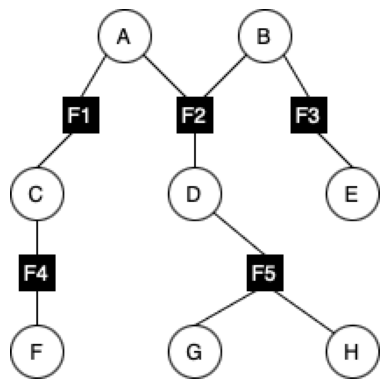

In [15]:
img = cv.imread("22.png")
plt.imshow(img)
plt.axis("off")
plt.show()

The expression for the joint probability can be written as below given the factor functions shown in the image above. Note that in the image, functions defined as 'F1' correspond to functions denoted as $f_1$ in the equation below.
$$ p(a,b,c,d,e,f,g) = f_1(a,c)f_2(a,b,d)f_3(b,e)f_4(c,f)f_5(d,g,h) $$

#### 2.3 (5 pts) Express the following Bayes net (from the sprinkler example) in two different factor graphs.  For each network, write the factors as a function of the conditional probabilties and specify the joint probability.

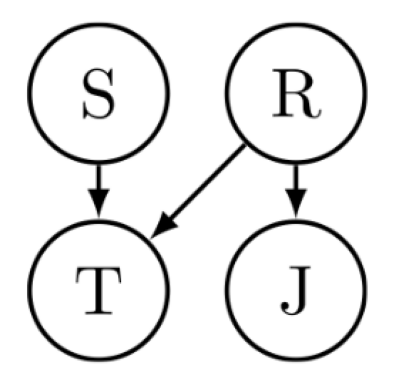

In [16]:
img = cv.imread("23problem.png")
plt.imshow(img)
plt.axis("off")
plt.show()

This Bayes Net can be expressed two ways as a factor graph. This is done by either adding factors for each set of connections or by adding factors for each node. Therefore, we can create two factor graphs which are visualized below. The probability distributions can be described as follows:

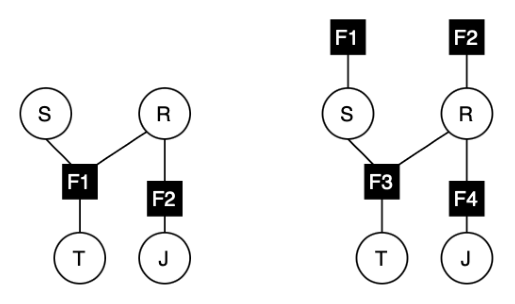

In [17]:
img = cv.imread("23.png")
plt.imshow(img)
plt.axis("off")
plt.show()

Factor Graph 1 (shown on the left):
$$ f_1(S, R, T) = p(T \mid S, R)p(S)p(R) $$
$$ f_2(R, J) = p(J \mid R) $$
$$ p(S, R, T, J) = f_1(S, R, T)f_2(R, J) = p(T \mid S, R)p(S)p(R)p(J \mid R) $$
<br><br>
Factor Graph 2 (shown on the right):
$$ f_1(S) = p(S) $$
$$ f_2(R) = p(R) $$
$$ f_3(S, R, T) = p(T \mid S, R) $$
$$ f_4(R, J) = p(J \mid R) $$
$$ p(S, R, T, J) = f_1(S)f_2(R)f_3(S, R, T)f_4(R, J) = p(S)p(R)p(T \mid S, R)p(J \mid R) $$

### Exercise 3. The Sum Product Algorithm (20 pts)

Consider the following factor graph.

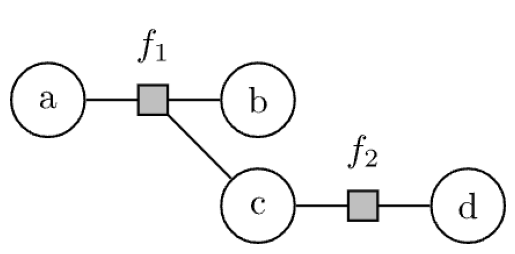

In [18]:
img = cv.imread("30problem.png")
plt.imshow(img)
plt.axis("off")
plt.show()

#### 3.1 (5 pts) Apply the sum-product algorithm to compute the all messages when none of the variables are known.  In your answers, you do not need to substitute in the values of other messages, i.e. your answers should be in terms of local factors and other messages. 
First, we can say that the message from a to $f_1$ is equal to the message from b to $f_1$ which is equal to the message from d to $f_2$ because they involve a single node input to a function and we know that the sum of each of these messages must be 1. From this, we can derive the following:
$$ 
\begin{align*}
    \mu_{a \to f_1} &= \mu_{b \to f_1} = \mu_{d \to f_2} = 1 \\
    \mu_{f_1 \to c} &= \sum_a \sum_b f_1(a, b, c) \mu_{a \to f_1} \mu_{b \to f_1} \\
    \mu_{f_2 \to c} &= \sum_d f_2(c, d)\mu_{d \to f_2}
\end{align*}
$$

#### 3.2 (5 pts) Compute the marginal probability $p(c)$, expressing it in terms of the messages you derived in the previous question.
$$
\begin{align*}
p(c) &= \mu_{f_1 \to c}\mu_{f_2 \to c} \\
    &=  \sum_a \sum_b f_1(a, b, c) \mu_{a \to f_1} \mu_{b \to f_1} \cdot \sum_d f_2(c, d)\mu_{d \to f_2} \\
    &= \sum_a \sum_b f_1(a, b, c)  \sum_d f_2(c, d)
\end{align*}
$$

#### 3.3 (5 pts) Verify that the marginal is the correct expression substituting in the message definitions.
$$
\begin{align*}
    p(c) &= \sum_a \sum_b \sum_d p(a, b, c, d) \\
    &= \sum_a \sum_b \sum_d f_1(a, b, c)  \sum_d f_2(c, d) \\
    &= \sum_a \sum_b f_1(a, b, c)  \sum_d f_2(c, d)
\end{align*}
$$

#### 3.4 (5 pts) Now consider adding a loop to the graph (shown below). Explore the consequences of applying the sum-product algorithm to this graph. Can the algorithm still be applied?

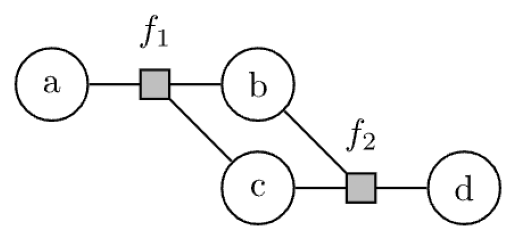

In [20]:
img = cv.imread("34problem.png")
plt.imshow(img)
plt.axis("off")
plt.show()

With a loop, we can define each of the messages as:

$$
\begin{align*}
    \mu_{a \to f_1} &= \mu_{d \to f_2} = 1 \\
    \mu_{b \to f_1} &= \mu_{f_2 \to b} \\
    \mu_{b \to f_2} &= \mu_{f_1 \to b} \\
    \mu_{f_1 \to b} &= \sum_a \sum_c f_1(a, b, c) \mu_{a \to f_1} \mu_{c \to f_1} \\
    \mu_{f_1 \to c} &= \sum_a \sum_b f_1(a, b, c) \mu_{a \to f_1} \mu_{b \to f_1} \\
    \mu_{f_2 \to b} &= \sum_c \sum_d f_2(b, c, d) \mu_{c \to f_2} \mu_{d \to f_2} \\
    \mu_{f_2 \to c} &= \sum_b \sum_d f_2(b, c, d) \mu_{b \to f_2} \mu_{d \to f_2}
\end{align*}
$$

Which provides the following probability:

$$
\begin{align*}
    p(c) &= \mu_{f_1 \to c} \mu_{f_2 \to c} \\
    &= \sum_a \sum_b f_1(a, b, c) \mu_{a \to f_1} \mu_{b \to f_1} \cdot \sum_b \sum_d f_2(b, c, d) \mu_{b \to f_2} \mu_{d \to f_2} \\
    &= \sum_a \sum_b f_1(a, b, c) \mu_{a \to f_1} \mu_{f_2 \to b} \cdot \sum_b \sum_d f_2(b, c, d) \mu_{d \to f_2} \mu_{f_1 \to b}   \\
    &=  \sum_a \sum_b f_1(a, b, c) \mu_{a \to f_1} \sum_c \sum_d f_2(b, c, d) \mu_{c \to f_2} \mu_{d \to f_2} \cdot \sum_b \sum_d f_2(b, c, d) \mu_{d \to f_2} \sum_a \sum_c f_1(a, b, c) \mu_{a \to f_1} \mu_{c \to f_1} \\
    &=  \sum_a \sum_b f_1(a, b, c) \sum_c \sum_d f_2(b, c, d) \mu_{c \to f_2} \cdot \sum_b \sum_d f_2(b, c, d)  \sum_a \sum_c f_1(a, b, c) \mu_{c \to f_1}\\
    &= \sum_a \sum_b f_1(a, b, c)  \mu_{f_2 \to b} \cdot \sum_b \sum_d f_2(b, c, d) \mu_{f_1 \to b} \\
    &...
\end{align*}
$$

Notice how the equation continues. This will eventually become an infinite loop including itself. Therefore, the sum-product algorithm cannot be applied in cases where there is a loop in the factor graph.